Compare the performance of VICE, DDL, and DynamicsAwareEmbeddingVICE on the Maze-v0 task.

In [6]:
!pip install dictdiffer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import pickle
import gzip
import tensorflow as tf
import glob
import math
import skimage
from matplotlib.patches import Rectangle
import json
from dictdiffer import diff
import pandas as pd

In [2]:
common_dir = '/home/kevinli/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'Maze-v0'

In [3]:
def get_exp_paths(nums=None):
    base_path = os.path.join(common_dir, universe, domain, task)
    exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))

    if not nums:
        for i, exp in enumerate(exps):
            print(f'{i} \t {exp.replace(base_path, "")}')
        exp_choices = input('\n Which experiment(s) do you want to analyze? (ENTER A NUMBER) \t')
        exp_numbers = []
        for num in exp_choices.split(","):
            exp_numbers.append(int(num))
    else:
        exp_numbers = nums

    return {num: exps[num] for num in exp_numbers}

def get_seed_dirs(exp_path):
    seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
    return [seed for seed in seeds if os.path.isdir(seed)]

def load_progress_for_all_paths(paths):
    progress = {}
    
    for exp_num, exp_path in paths.items():
        seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
        seeds = [seed for seed in seeds if os.path.isdir(seed)]
        exp_data = {}
        for i, seed in enumerate(seeds):
        #     print(f'{i} \t {seed.replace(exp_path, "")}')
            try:
                progress_file = os.path.join(seed, "progress.csv")
                df = pd.read_csv(progress_file)
                with open(os.path.join(seed, 'params.json')) as f:
                    params = json.load(f)
                exp_data[seed] = {"progress": df, "params": params}
            except Exception as e:
                print(e)

        print(f"Loaded {len(exp_data)} seeds from {exp_path.split('/')[-1]}")
        progress[exp_num] = exp_data

    return progress

# Seed Comparison

In [4]:
exp1, exp2 = list(get_exp_paths().values())

# Compare the first seed in exp1 to all the seeds in exp2
seed1 = get_seed_dirs(exp1)[0]
seeds2 = get_seed_dirs(exp2)

with open(os.path.join(seed1, 'params.json')) as f:
    params1 = json.load(f)
    
print(f"Comparing {seed1} to:")
print("=" * 20)

for seed_dir in seeds2:
    with open(os.path.join(seed_dir, 'params.json')) as f:
        params2 = json.load(f)
        
    diffs = list(diff(params1, params2))
    print(f"{seed_dir}: {json.dumps(diffs, indent=4)}")

0 	 /2020-05-27T16-46-37-ddl_maze
1 	 /2020-05-27T18-08-07-ddl_maze_count
2 	 /2020-05-28T03-25-55-vice_test
3 	 /2020-05-28T03-28-00-vice_test
4 	 /2020-05-28T03-31-57-vice_test
5 	 /2020-05-28T03-33-32-vice_test
6 	 /2020-05-28T03-44-54-vice_test
7 	 /2020-05-28T15-34-01-dynamics_aware_vice
8 	 /2020-05-29T03-42-04-dynamics_aware_vice_shorter_paths
9 	 /2020-05-29T03-47-53-vice_only
10 	 /2020-05-29T16-15-18-vice_only_final
11 	 /2020-05-31T05-25-18-vice_gt_embedding
12 	 /2020-06-02T02-47-31-vice_gt_embedding_rerun
13 	 /2020-06-02T03-22-25-vice_gt_embedding_more_reg
14 	 /2020-06-02T10-48-03-vice_gt_embedding_again
15 	 /2020-06-03T00-23-13-high_reg_vice
16 	 /2020-06-03T06-19-35-vice_dropout_and_wd
17 	 /2020-06-04T16-33-57-vice_gt_pairwise_embedding
18 	 /2020-06-05T00-51-54-vice_gt_pairwise_embedding_rerun
19 	 /2020-06-05T00-52-40-vice_gt_pairwise_embedding_rerun
20 	 /2020-06-05T01-03-06-vice_gt_pairwise_embedding_rerun_real
21 	 /2020-06-05T11-52-19-vice_gt_pairwise_embedding

E0615 12:35:49.382819 140296860346176 ultratb.py:152] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/kevinli/anaconda3/envs/softlearning/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 884, in _input_request
    ident, reply = self.session.recv(self.stdin_socket, 0)
  File "/home/kevinli/anaconda3/envs/softlearning/lib/python3.7/site-packages/jupyter_client/session.py", line 813, in recv
    msg_list = socket.recv_multipart(mode, copy=copy)
  File "/home/kevinli/anaconda3/envs/softlearning/lib/python3.7/site-packages/zmq/sugar/socket.py", line 475, in recv_multipart
    parts = [self.recv(flags, copy=copy, track=track)]
  File "zmq/backend/cython/socket.pyx", line 791, in zmq.backend.cython.socket.Socket.recv
  File "zmq/backend/cython/socket.pyx", line 827, in zmq.backend.cython.socket.Socket.recv
  File "zmq/backend/cython/socket.pyx", line 186, in zmq.backend.cython.socket._recv_copy
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt

During handling of the above exc

TypeError: can only concatenate str (not "list") to str

# Algorithm Comparison

In [7]:
nums_to_info = {
    34: {
        'name': 'DDL with raw state',
        'color': 'y'
    },
    39: {
        'name': 'VICE with raw state',
        'color': 'r'
    },
    48: {
        'name': 'VICE with dynamics embedding',
        'color': 'b'
    },
    50: {
        'name': 'VICE with pretrained embedding',
        'color': 'g'
    }
}
nums = nums_to_info.keys()

exp_paths = get_exp_paths(nums)
progress_data = load_progress_for_all_paths(exp_paths)

Loaded 12 seeds from 2020-06-09T14-32-56-ddl_rerun_count
Loaded 8 seeds from 2020-06-11T23-17-15-vice_reproduce_justins
No columns to parse from file
No columns to parse from file
Loaded 6 seeds from 2020-06-15T02-59-21-vice_online_final
Loaded 9 seeds from 2020-06-15T03-25-13-vice_offline_final


In [8]:
IGNORE_RUNS_BY_EXP_NUMS = {
    46: lambda params: params['algorithm_params']['kwargs']['n_classifier_train_steps'] != 2,
    39: lambda params: params['algorithm_params']['kwargs']['n_classifier_train_steps'] != 2
}

def ignore_run(exp_num, params):
    if exp_num not in IGNORE_RUNS_BY_EXP_NUMS:
        return False
    return IGNORE_RUNS_BY_EXP_NUMS[exp_num](params)

def get_exp_label(exp_num):
    return nums_to_info.get(exp_num, {}).get('name', None) or 'Unknown experiment'

def get_exp_color(exp_num):
    return nums_to_info.get(exp_num, {}).get('color', None) or 'r'

def double_std(a):
    return 2 * np.std(a)

def plot_stat(progress_data, stats):
    plt.figure(figsize=(16,8))
    colors = ['r', 'g', 'b', 'c']
    for i, (exp_num, exp_data) in enumerate(progress_data.items()):
        results_all_seeds = [
            exp_data['progress'].filter(stats) for exp_data in exp_data.values()
                if not ignore_run(exp_num, exp_data['params'])
        ]
        combined_results = pd.concat(results_all_seeds).groupby(level=0).mean()
        
        plt.plot(combined_results, color=get_exp_color(exp_num), linewidth=2, label=get_exp_label(exp_num))
        
        for result in results_all_seeds:
            plt.plot(result, color=get_exp_color(exp_num), alpha=0.08)
    
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}k"))
    plt.ylim(0, 22)
    plt.xlabel("Training steps")
    plt.ylabel("Manhattan distance to goal")
    plt.title("Medium Maze-v0")
    plt.legend()
    plt.show()

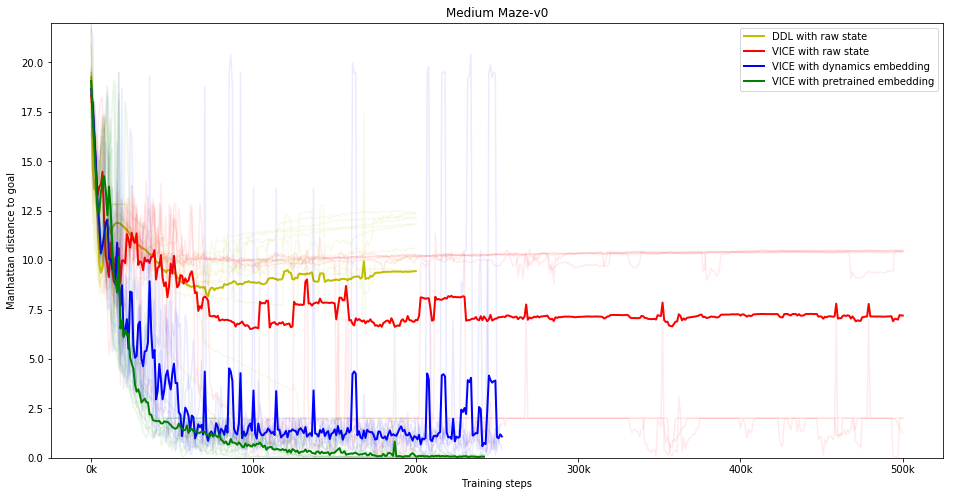

In [9]:
plot_stat(progress_data, ['evaluation/env_infos/manhattan_dist_to_target-last-mean'])